In [1]:
import re
import copy
import numpy as np
import pandas as pd
import multiprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit # or StratifiedShuffleSplit

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from pymystem3 import Mystem
import tqdm


import nltk
from wordcloud import WordCloud
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Dropout, Linear, CrossEntropyLoss, Module, ReLU, GRU, Embedding
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel

## EDA и предобработка

In [2]:
df = pd.read_csv('women-clothing-accessories.3-class.balanced.csv', sep='\t')
df.head()

review sentiment
0  качество плохое пошив ужасный (горловина напер...  negative
1  Товар отдали другому человеку, я не получила п...  negative
2  Ужасная синтетика! Тонкая, ничего общего с пре...  negative
3  товар не пришел, продавец продлил защиту без м...  negative
4      Кофточка голая синтетика, носить не возможно.  negative

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     90000 non-null  object
 1   sentiment  90000 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


90 000 отзывов с окраской. Пропусков нет.

In [4]:
df.duplicated().sum()

2250

Есть дубликаты. Возможно добавили для борьбы с дисбалансом, однако их не так много и дисбаланс был небольшой. Удаляем.

In [5]:
df = df.drop_duplicates()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87750 entries, 0 to 89999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     87750 non-null  object
 1   sentiment  87750 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


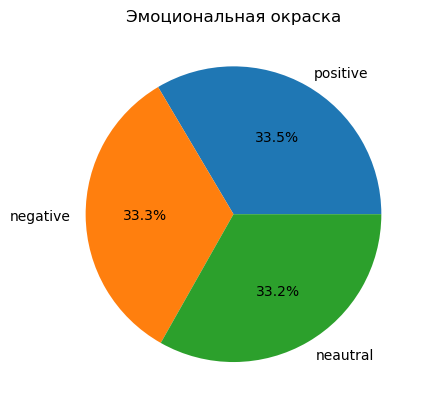

In [7]:
df['sentiment'].value_counts().plot.pie(autopct = '%1.1f%%', 
                                         title="Эмоциональная окраска", ylabel='');

Отношение классов 1:1:1. Закодируем метки классов.

In [8]:
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [9]:
label_encoder.classes_

array(['neautral', 'negative', 'positive'], dtype=object)

### Очистка
Функция очистки данных с помощью регулярных выражений. Данная функция будет полезна и в случае сентимент анализа с помощью классических алгоритмов, так и с помощью глубокого обучения.

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\sа-яё0-9]',' ',text)
    text = re.sub(r'\w*\d+\w*', ' ', text)
    text = re.sub('\s{2,}', " ", text)
    return text

df['review'] = df['review'].apply(clean_text)
df.head()

review  sentiment
0  качество плохое пошив ужасный горловина напере...          1
1  товар отдали другому человеку я не получила по...          1
2  ужасная синтетика тонкая ничего общего с предс...          1
3  товар не пришел продавец продлил защиту без мо...          1
4       кофточка голая синтетика носить не возможно           1

Можно посмотреть на некоторые статистики по тексту.

In [11]:
df["review"].apply(lambda s: len(s)).describe()

count    87750.000000
mean       123.112912
std        117.874613
min          1.000000
25%         50.000000
50%         87.000000
75%        155.000000
max        987.000000
Name: review, dtype: float64

Максимальная длина отзыва 987, минимальная - 1 символ (??).

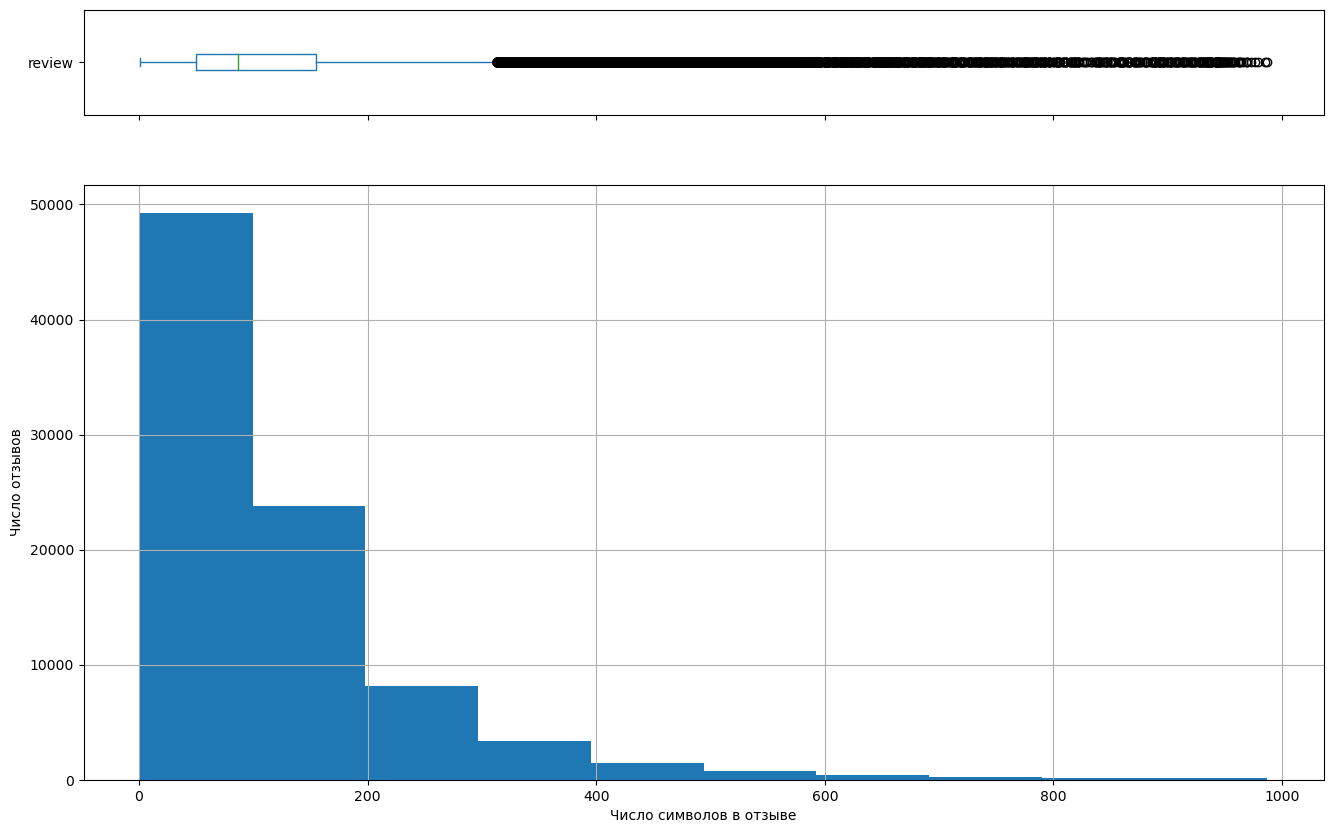

In [12]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(16,10), 
                                    gridspec_kw={"height_ratios": (.15, .85)})
df["review"].apply(lambda s: len(s)).plot.box(ax=ax_box, vert=False)
df["review"].apply(lambda s: len(s)).hist(ax=ax_hist);
plt.xlabel("Число символов в отзыве")
plt.ylabel("Число отзывов");

Отбросим отзывы с числом симполов меньше 5 и больше 400.

In [13]:
df = df[(df['review'].apply(lambda s: len(s)) <= 400) & (df['review'].apply(lambda s: len(s)) >= 5)]

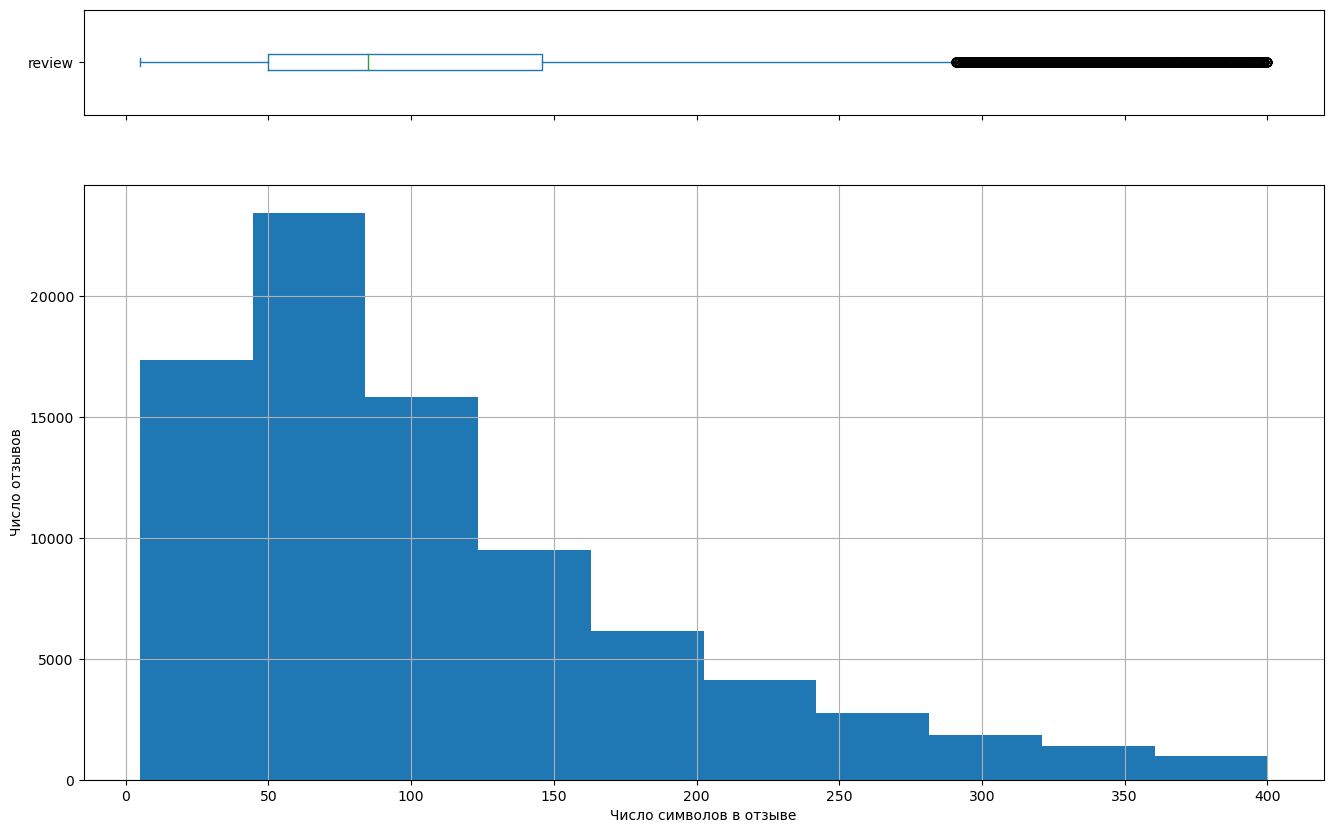

In [14]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(16,10), 
                                    gridspec_kw={"height_ratios": (.15, .85)})
df["review"].apply(lambda s: len(s)).plot.box(ax=ax_box, vert=False)
df["review"].apply(lambda s: len(s)).hist(ax=ax_hist);
plt.xlabel("Число символов в отзыве")
plt.ylabel("Число отзывов");

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83441 entries, 0 to 89999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     83441 non-null  object
 1   sentiment  83441 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 1.6+ MB


In [16]:
df["review"].apply(lambda s: len(s.split())).describe()

count    83441.000000
mean        17.459378
std         13.268184
min          1.000000
25%          8.000000
50%         13.000000
75%         23.000000
max         77.000000
Name: review, dtype: float64

Среднее число слов (включая стоп-слова -17.

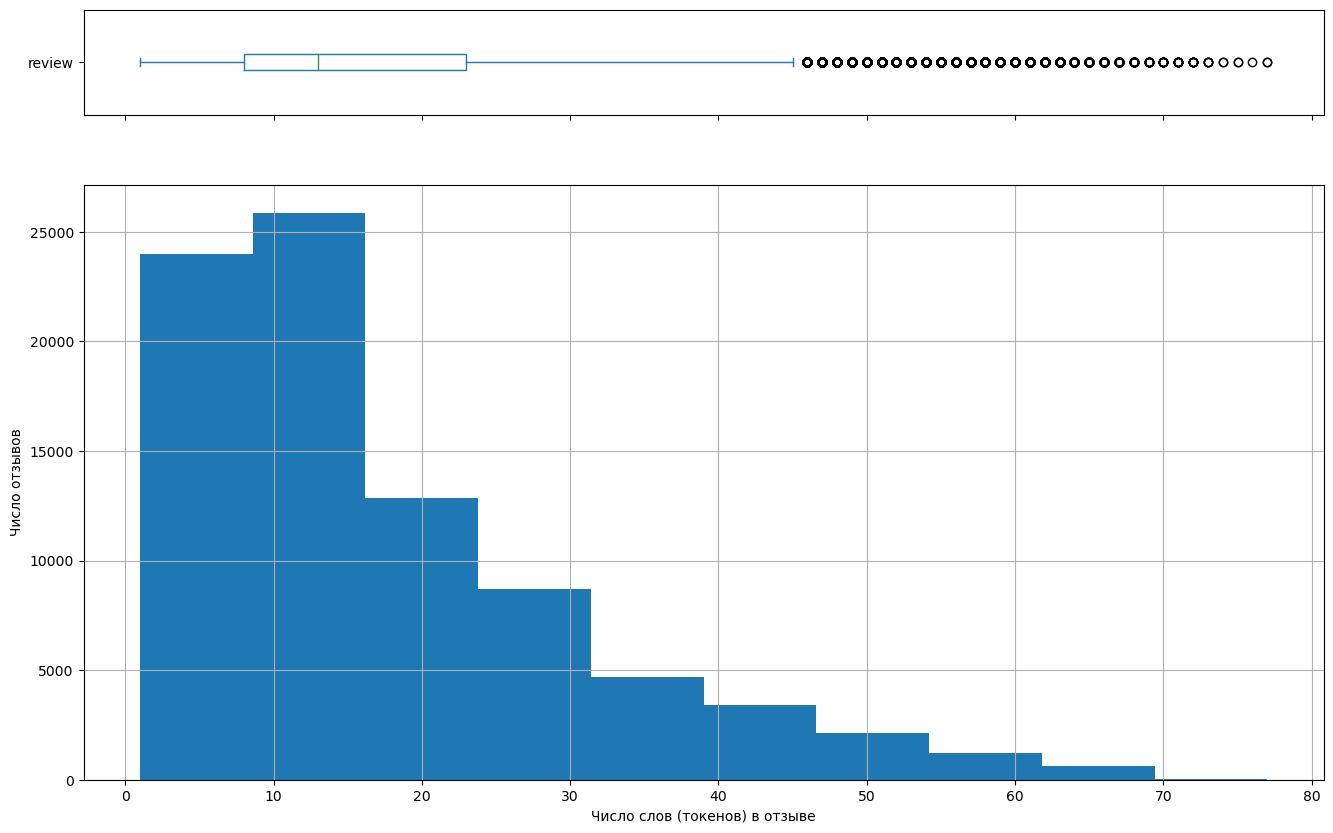

In [17]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(16,10), 
                                    gridspec_kw={"height_ratios": (.15, .85)})
df["review"].apply(lambda s: len(s.split())).plot.box(ax=ax_box, vert=False)
df["review"].apply(lambda s: len(s.split())).hist(ax=ax_hist);
plt.xlabel("Число слов (токенов) в отзыве")
plt.ylabel("Число отзывов");

Найдём самые часто встречаемые слова и отобразим с помощью облака слов.

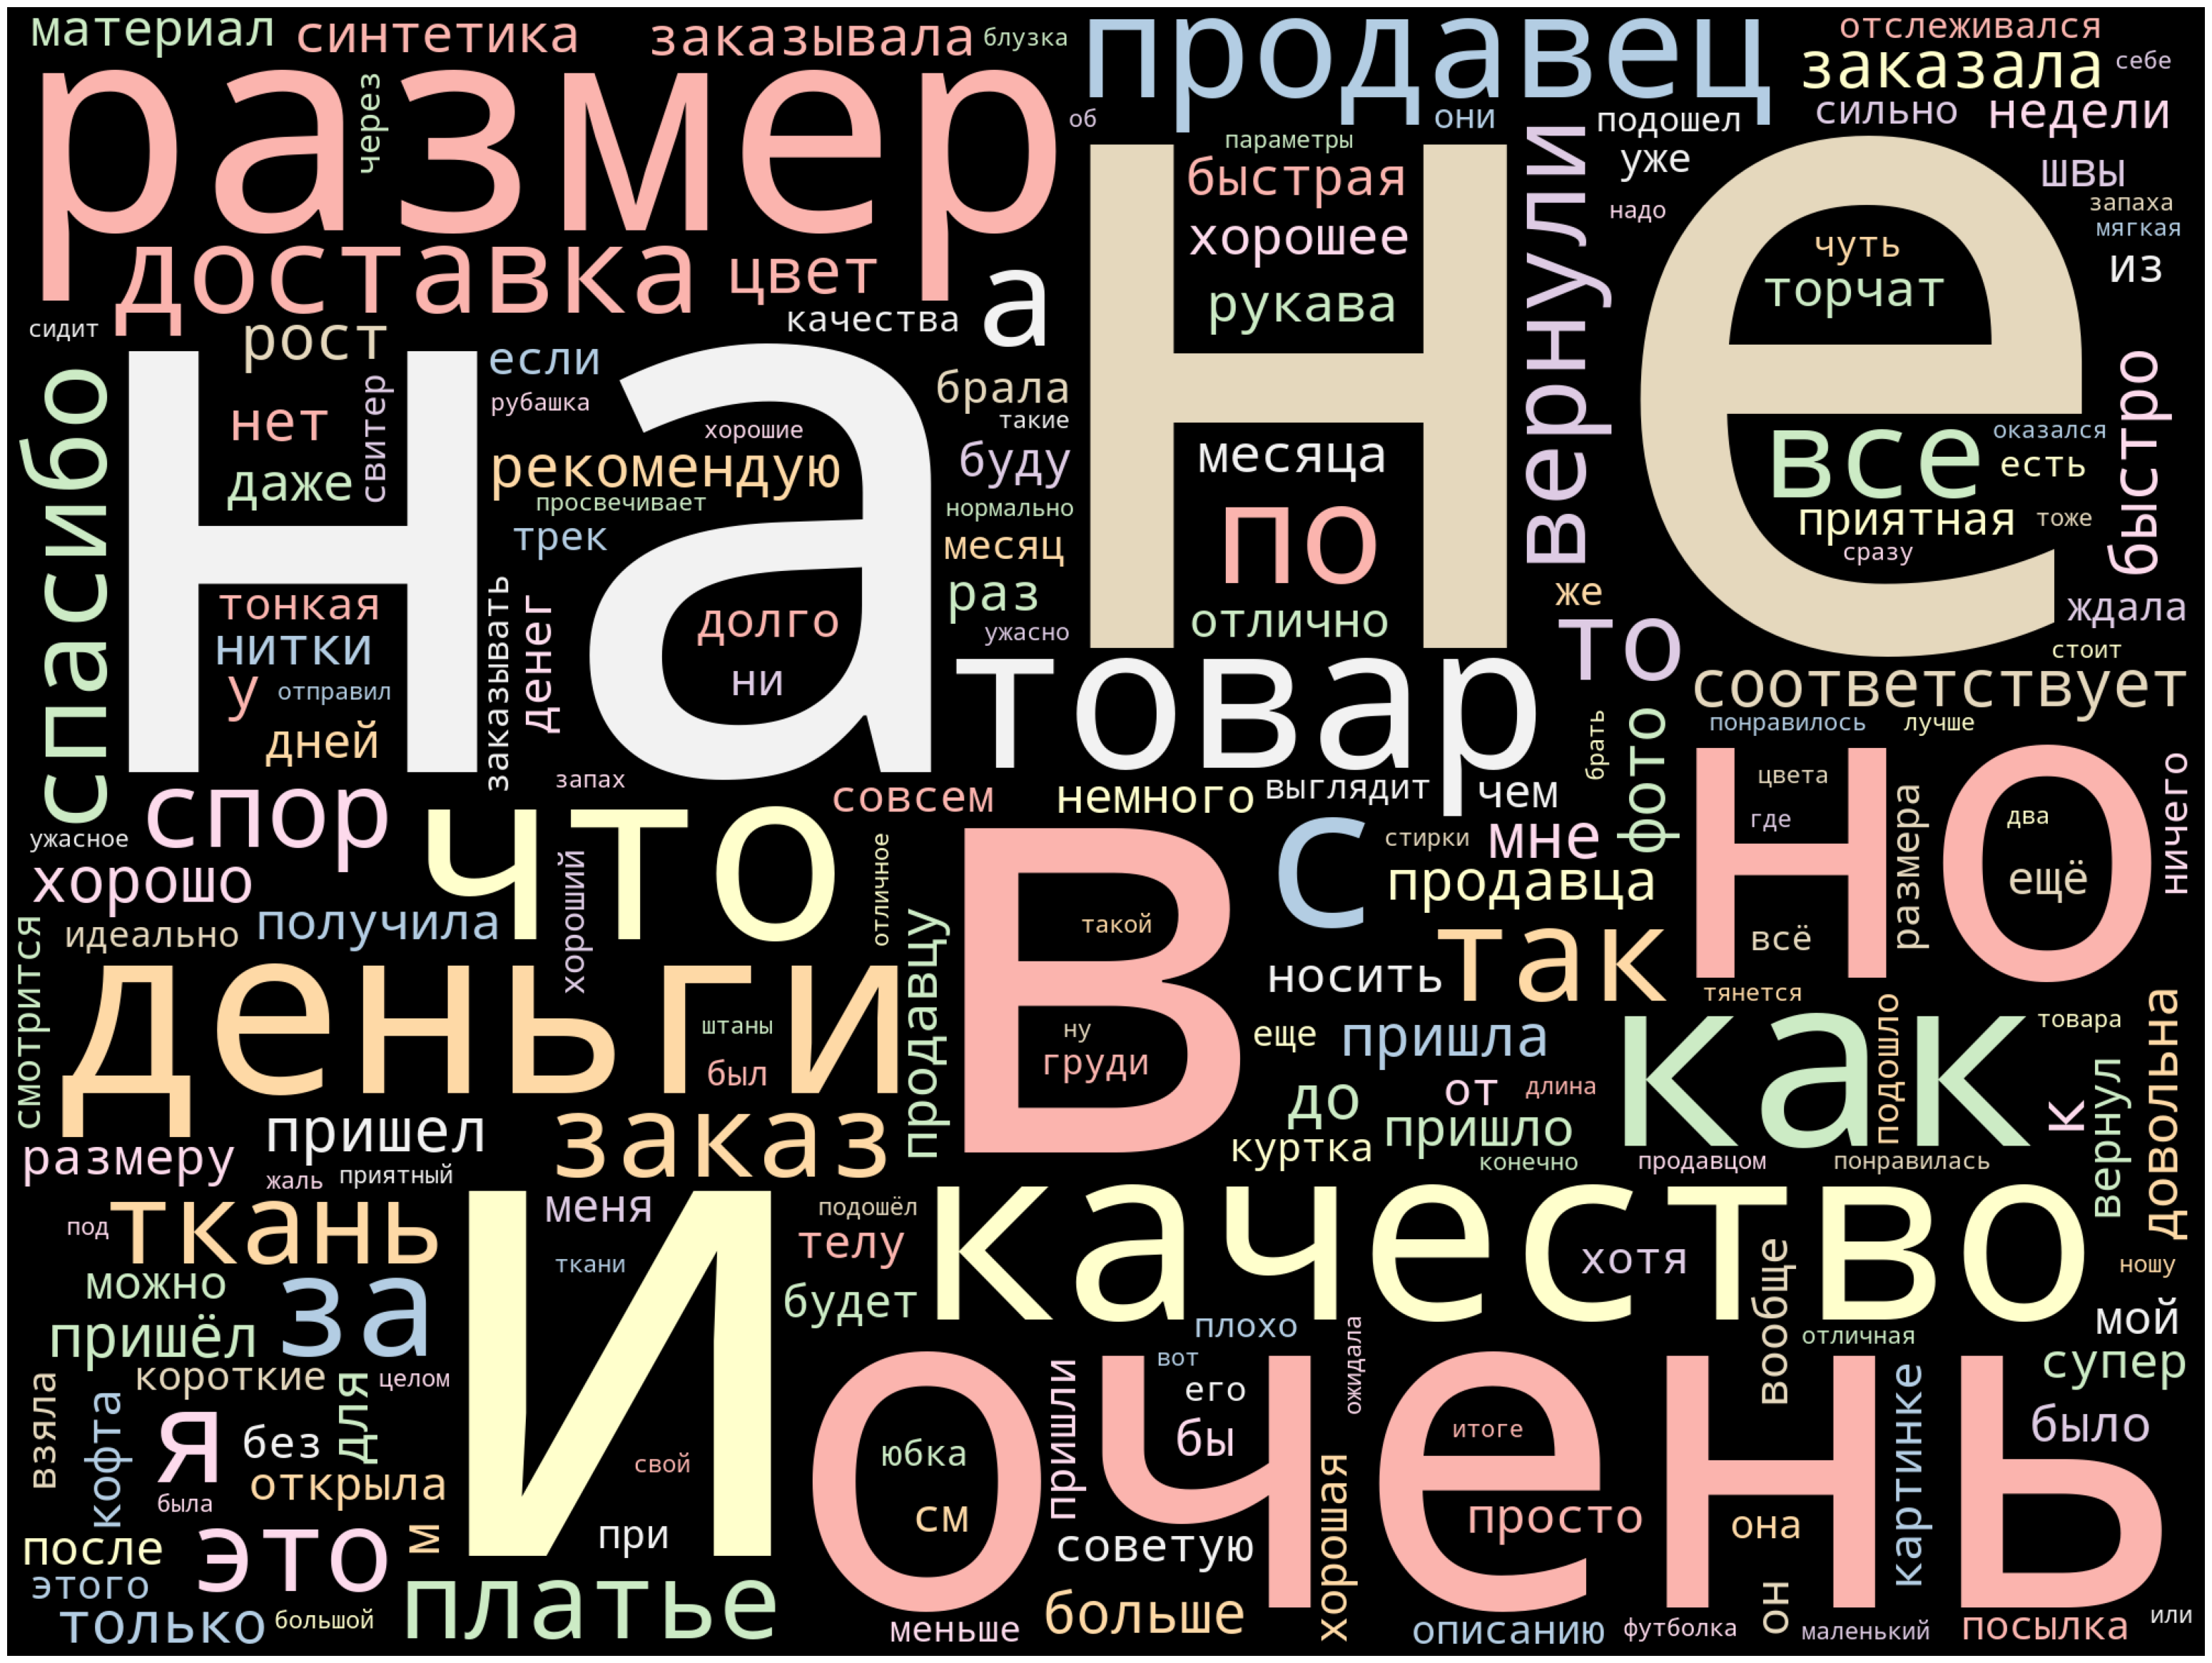

In [18]:
SEED = 1234
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off")

wordcloud = WordCloud(width = 2000, 
                      height = 1500, 
                      random_state=SEED, 
                      background_color='black', 
                      margin=20, 
                      colormap='Pastel1', 
                      collocations=False).generate(" ".join(df.review.str.split().explode().to_list()))

plot_cloud(wordcloud)

Посмотрим без стоп слов.

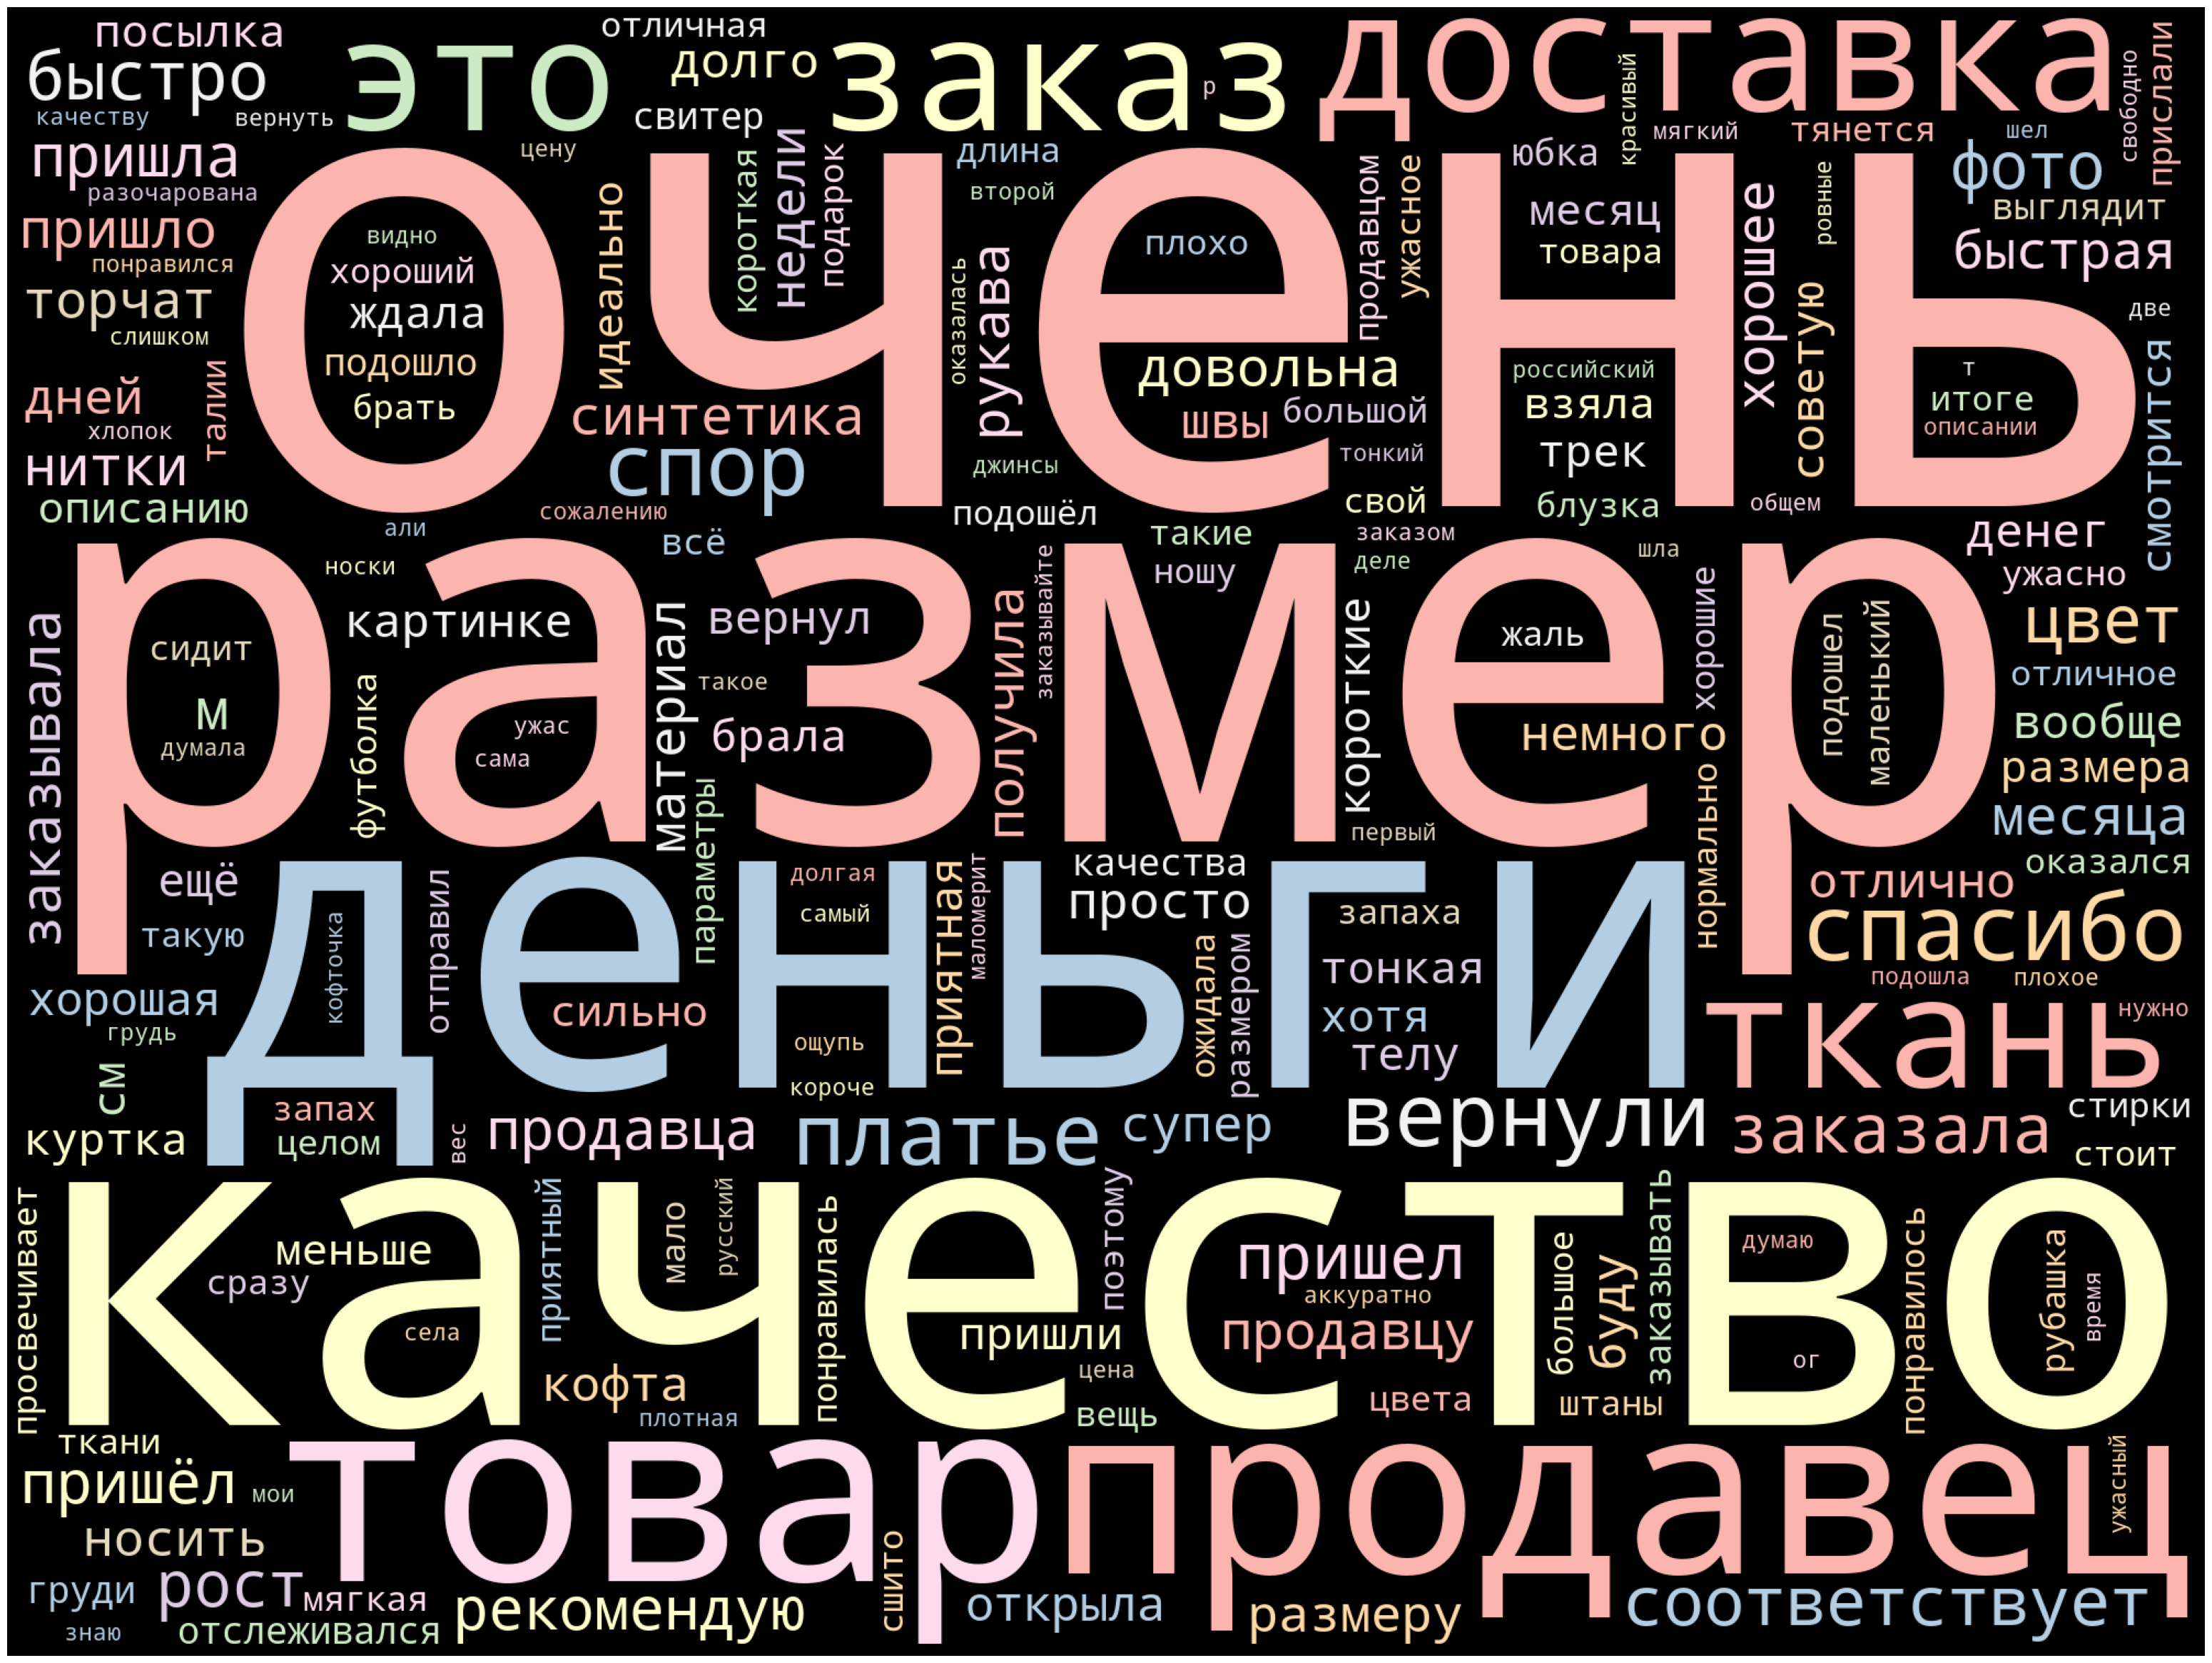

In [19]:
wordcloud = WordCloud(width = 2000, 
                      height = 1500, 
                      random_state=SEED, 
                      background_color='black', 
                      margin=20, 
                      colormap='Pastel1', 
                      collocations=False,
                      stopwords=nltk.corpus.stopwords.words("russian")).generate(" ".join(df.review.str.split().explode().to_list()))

plot_cloud(wordcloud)

По-поводу очистки от стоп-слов, как видим, не всё так просто - пропадают частицы отрицания, что может сказаться даже на классических вариантах сентимент анализа.

### Лемматизация

Лемматизация и стемминг полезны в классических алгоритмах, что касается их примения в глубоком обучении - ведутся споры. Для русского языка есть библиотека mystem3, и pymorphy3. Создадим, ещё один вариант текста с лемматизацией.

In [20]:
import re

from pymorphy3 import MorphAnalyzer
from nltk.corpus import stopwords

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    return tokens
df["review_lemma"] = df['review'].apply(lemmatize)
df.head()

review  sentiment  \
0  качество плохое пошив ужасный горловина напере...          1   
1  товар отдали другому человеку я не получила по...          1   
2  ужасная синтетика тонкая ничего общего с предс...          1   
3  товар не пришел продавец продлил защиту без мо...          1   
4       кофточка голая синтетика носить не возможно           1   

                                        review_lemma  
0  [качество, плохой, пошив, ужасный, горловина, ...  
1  [товар, отдать, другой, человек, я, не, получи...  
2  [ужасный, синтетик, тонкий, ничего, общий, с, ...  
3  [товар, не, прийти, продавец, продлить, защита...  
4  [кофточка, голый, синтетик, носить, не, возможно]

In [21]:
def to_join(lst):
    string = ''
    if lst is None:
        return ''
    else:
        for el in lst:
            string += ' '
            string += el
        return string
df["review_lemma"] = df['review_lemma'].apply(to_join)
df.head()

review  sentiment  \
0  качество плохое пошив ужасный горловина напере...          1   
1  товар отдали другому человеку я не получила по...          1   
2  ужасная синтетика тонкая ничего общего с предс...          1   
3  товар не пришел продавец продлил защиту без мо...          1   
4       кофточка голая синтетика носить не возможно           1   

                                        review_lemma  
0   качество плохой пошив ужасный горловина напер...  
1   товар отдать другой человек я не получить пос...  
2   ужасный синтетик тонкий ничего общий с предст...  
3   товар не прийти продавец продлить защита без ...  
4         кофточка голый синтетик носить не возможно

In [39]:
from pymystem3 import Mystem
mystem = Mystem()
df["review_lemma"] = df['review'].apply(lambda s: "".join(mystem.lemmatize(s)))
df.head()

KeyboardInterrupt: 

## Эмбеддинги

Есть несколько вариантов эмбеддингов. В классическом ML используются эмбеддинги всего предложения (текста); в глубоком с использованием свёрток, трансформеров и сетей с памятью используются последовательность эмбеддингов отдельных слов.

### Мешок слов

In [22]:
count_vectorizer = CountVectorizer()
X_bag = count_vectorizer.fit_transform(df['review_lemma'])
X_bag.shape

(83441, 20348)

Очень высокая размерность признакового пространства, даже без добавления N-грамм. Можно попробовать понизить используя SVD.

N_DIM:100 - 0.5858187708984558
N_DIM:200 - 0.7038054154019269
N_DIM:300 - 0.7669831601281213
N_DIM:400 - 0.8087284507631929
N_DIM:500 - 0.8375685560170911
N_DIM:600 - 0.8585528242192919
N_DIM:700 - 0.8750341101266751
N_DIM:800 - 0.8883877820854373
N_DIM:900 - 0.899423872284753
N_DIM:1000 - 0.9087560302131076


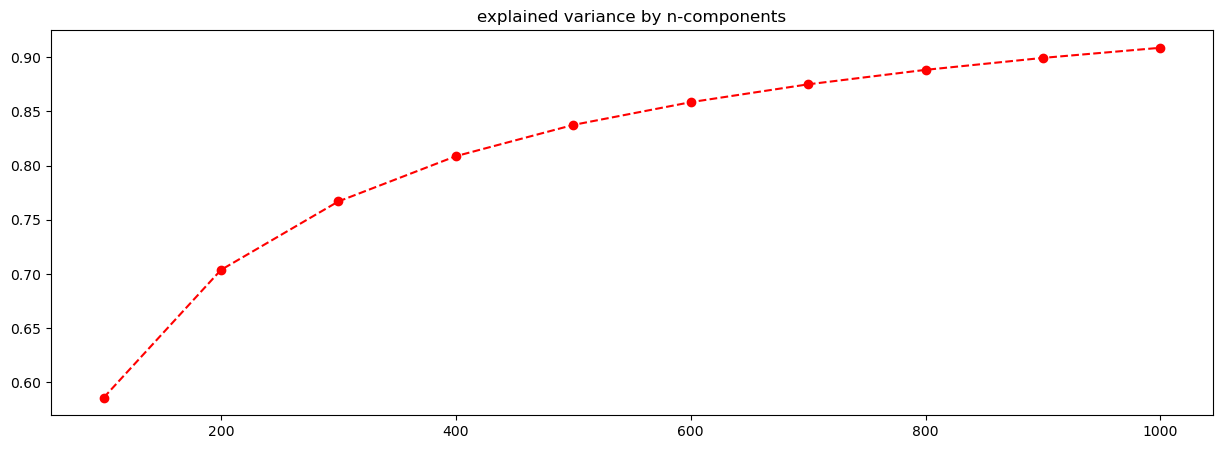

In [164]:
performance = []
test = range(100, 1100, 100)

for n in test:
    svd = TruncatedSVD(n_components=n, random_state=SEED)
    lsa = svd.fit(X_bag)
    lsa.explained_variance_ratio_.sum()
    expl_var_ratio_sum = lsa.explained_variance_ratio_.sum()
    print(f"N_DIM:{n} - {expl_var_ratio_sum}")
    performance.append(expl_var_ratio_sum)

fig = plt.figure(figsize=(15, 5))
plt.plot(test, performance, 'ro--')
plt.title('explained variance by n-components');

После 600 сумма доли учтенной дисперсии уменьшается медленно. Поэтому имеет смысл ограничиться именно этим значением.  Итак:

In [35]:
X_bag_lsa = TruncatedSVD(n_components=600).fit_transform(X_bag)
X_bag_lsa.shape

(83441, 600)

### TF-IDF

In [36]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['review_lemma'])
X_tfidf.shape

(83441, 20348)

N_DIM:100 - 0.3463980639448006
N_DIM:200 - 0.47285776126026013
N_DIM:300 - 0.5514649234170108
N_DIM:400 - 0.6084178247771507
N_DIM:500 - 0.6511217092651586
N_DIM:600 - 0.6849758460079303
N_DIM:700 - 0.7127067763226337
N_DIM:800 - 0.7358510734919759
N_DIM:900 - 0.7556904053239848
N_DIM:1000 - 0.7730105285031823


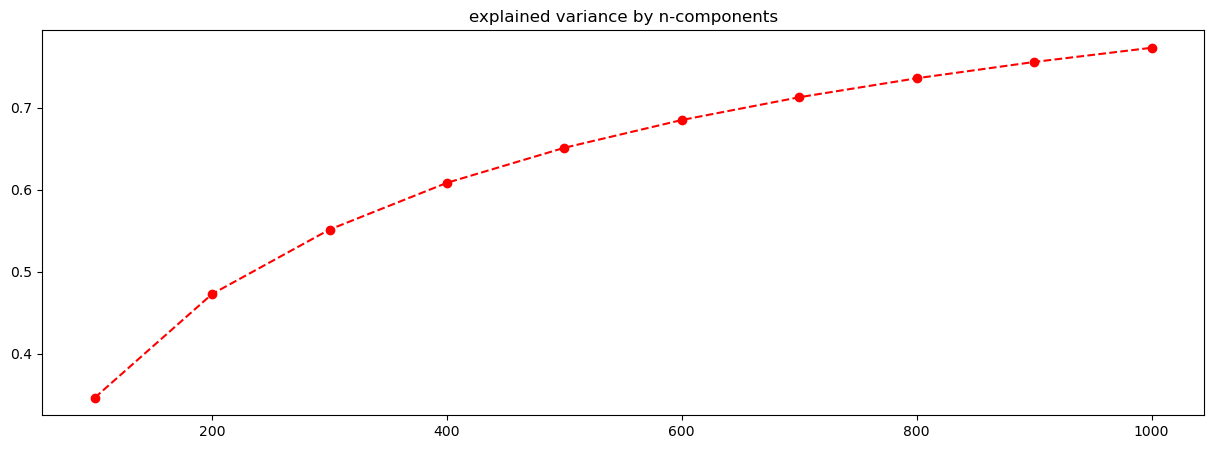

In [167]:
performance = []
test = range(100, 1100, 100)

for n in test:
    svd = TruncatedSVD(n_components=n)
    lsa = svd.fit(X_tfidf)
    lsa.explained_variance_ratio_.sum()
    expl_var_ratio_sum = lsa.explained_variance_ratio_.sum()
    print(f"N_DIM:{n} - {expl_var_ratio_sum}")
    performance.append(expl_var_ratio_sum)

fig = plt.figure(figsize=(15, 5))
plt.plot(test, performance, 'ro--')
plt.title('explained variance by n-components');

In [37]:
X_tfidf_lsa = TruncatedSVD(n_components=900).fit_transform(X_tfidf)
X_tfidf_lsa.shape

(83441, 900)

### Word2Vec (mean embedding) обучение

Составляем список N-gram (Bi)

In [38]:
sent = [row.split() for row in df['review_lemma']]

In [39]:
phrases = Phrases(sent, min_count=1, threshold=1)


In [40]:
bigram = Phraser(phrases)

In [41]:
sentences = bigram[sent]

In [42]:
sentences

Проверяем сет для тренировки модели.

In [43]:
from collections import defaultdict
import time
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

49247

In [44]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['и', 'не', 'но', 'на', 'размер', 'я', 'продавец', 'быть', 'в', 'прийти']

In [45]:
cores = multiprocessing.cpu_count() 

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

Создаём словарь.

In [46]:
w2v_model.build_vocab(sentences)

Тренируем модель.

In [47]:
t = time.time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to train the model: 0.76 mins


Сохраняем модель.

In [48]:
w2v_model.save('w2v_bigramm_300.w2v')

In [49]:
w2v_model.init_sims(replace=True)

C:\Users\ANTON\AppData\Local\Temp\ipykernel_14208\514372312.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


Векторизуем текст, как в режиме word так и sentence. Ограничим последовтательность 73словами и будем добавлять отбивку из нулевых 300-мерных векторов.

In [50]:
MAX_LEN = 0
for sent in df["review_lemma"].tolist():
    swn = 0
    for word in sent.split():
        if word in w2v_model.wv:
            swn+=1
    MAX_LEN = max(swn, MAX_LEN)
MAX_LEN

74

In [51]:
MAX_LEN = 74
S_EMB = []
for sent in df["review_lemma"].tolist():
    WS_EMB = []
    for word in sent[:MAX_LEN]:
        if word in w2v_model.wv:
            WS_EMB.append(w2v_model.wv[word])
    S_EMB.append(np.vstack(WS_EMB).mean(axis=0))

In [52]:
X_w2v_sent = np.vstack(S_EMB)
X_w2v_sent.shape

(83441, 300)

### LaBSE
Эмбендинг для всего текста, работает, как с классичеческими моделями, так и с полносвязной НС. Пуллинг основан на CLS токенах. Так как может хорошо улавливать и контекст слов, лучше использовать не лемматизированный текст.

In [57]:
model_name = "cointegrated/LaBSE-en-ru"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

C:\Users\ANTON\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Максимальная длина предложения ~80 слов. В качестве токенизатора модель использует BPE, поэтому число токенов врятли превысит 200.

In [58]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = 'true'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device('cpu')
X_labse_list = []
for sent in tqdm.tqdm(df['review'].tolist()):
    encoded_input = tokenizer(sent, padding=True, truncation=True, max_length=200,
                              add_special_tokens=True, return_tensors='pt')
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)
    embeddings = model_output.pooler_output
    X_labse_list.append(torch.nn.functional.normalize(embeddings)[0].cpu())

100%|██████████| 83441/83441 [1:11:33<00:00, 19.43it/s]


In [59]:
X_labse_tensor = torch.stack(X_labse_list)

In [60]:
X_labse_tensor.shape

torch.Size([83441, 768])

In [61]:
with open('X_labse_tensor.pt', 'wb') as f:
    torch.save(X_labse_tensor, f)

In [62]:
X_labse_tensor = torch.load("X_labse_tensor.pt")

C:\Users\ANTON\AppData\Local\Temp\ipykernel_14208\3133385503.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_labse_tensor = torch.load("X_labse_tensor.pt")


In [63]:
X_labse = X_labse_tensor.numpy()

In [64]:
del model
del S_EMB
del X_labse_list
del w2v_model

In [65]:
import gc
gc.collect()

10

## Классический ML

Выделим отдельную тестовую выборку (10%) для окончательной валидации и её индексы для выделение тестового датасета из разных эмбеддингов.

In [23]:
y = df["sentiment"].values
sss = ShuffleSplit(n_splits=1, test_size=0.1, random_state = SEED)

sss.get_n_splits(X_bag, y)
train_index, test_index = next(sss.split(X_bag, y)) 
y_train, y_test = y[train_index], y[test_index] 

### Logistic Regression

#### Мешок слов

In [67]:
X_bag_train, X_bag_test = X_bag[train_index], X_bag[test_index] 
bag_logreg = LogisticRegression(random_state=SEED, max_iter=5000)
params_log = {'C': np.logspace(start = -3, stop = 2, num = 6)}
clf_lr_bag = GridSearchCV(bag_logreg, params_log,  scoring='accuracy', n_jobs=6,verbose=3)
clf_lr_bag.fit(X_bag_train, y_train)
print(f"The best score: {clf_lr_bag.best_score_:.3f} for C: {clf_lr_bag.best_params_['C']}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best score: 0.737 for C: 0.1


#### Мешок слов LSA

In [68]:
X_bag_lsa_train, X_bag_lsa_test = X_bag_lsa[train_index], X_bag_lsa[test_index] 
bag_lsa_logreg = LogisticRegression(random_state=SEED, max_iter=5000)
clf_lr_bag_lsa = GridSearchCV(bag_lsa_logreg, params_log,  scoring='accuracy', n_jobs=6,verbose=3)
clf_lr_bag_lsa.fit(X_bag_lsa_train, y_train)
print(f"The best score: {clf_lr_bag_lsa.best_score_:.3f} for C: {clf_lr_bag_lsa.best_params_['C']}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best score: 0.729 for C: 0.1


От LSA метрика незначительно упала, видимо немного информации потерялось при преобразовании.

#### TF-IDF

In [46]:
X_tfidf_train, X_tfidf_test = X_tfidf[train_index], X_tfidf[test_index] 
tfidf_logreg = LogisticRegression(random_state=SEED, max_iter=5000)
clf_lr_tfidf = GridSearchCV(tfidf_logreg, params_log,  scoring='accuracy', n_jobs=6,verbose=3)
clf_lr_tfidf.fit(X_tfidf_train, y_train)
print(f"The best score: {clf_lr_tfidf.best_score_:.3f} for C: {clf_lr_tfidf.best_params_['C']}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best score: 0.735 for C: 1.0


Применение на данном датасете tf-idf вместо bag-of-words практически ничего не поменяло.

#### TF-IDF-LSA

In [47]:
X_tfidf_lsa_train, X_tfidf_lsa_test = X_tfidf_lsa[train_index], X_tfidf_lsa[test_index] 
tfidf_lsa_logreg = LogisticRegression(random_state=SEED, max_iter=5000)
clf_lr_tfidf_lsa = GridSearchCV(tfidf_lsa_logreg, params_log,  scoring='accuracy', n_jobs=6,verbose=3)
clf_lr_tfidf_lsa.fit(X_tfidf_lsa_train, y_train)
print(f"The best score: {clf_lr_tfidf_lsa.best_score_:.3f} for C: {clf_lr_tfidf_lsa.best_params_['C']}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best score: 0.732 for C: 1.0


Тоже немного ниже, чем на полноразмерных векторах.

#### W2V (mean)

In [51]:
X_w2v_train, X_w2v_test = X_w2v_sent[train_index], X_w2v_sent[test_index] 
w2v_logreg = LogisticRegression(random_state=SEED, max_iter=5000)
clf_lr_w2v = GridSearchCV(w2v_logreg, params_log,  scoring='accuracy', n_jobs=6,verbose=3)
clf_lr_w2v.fit(X_w2v_train, y_train)
print(f"The best score: {clf_lr_w2v.best_score_:.3f} for C: {clf_lr_w2v.best_params_['C']}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best score: 0.484 for C: 100.0


Плохо работает на этом датасете с этой моделью, есть версия, что из за низкой размерности.

#### LaBSE

In [52]:
X_labse.shape

(83441, 768)

In [71]:
X_labse_train, X_labse_test = X_labse[train_index], X_labse[test_index] 
labse_logreg = LogisticRegression(random_state=SEED, max_iter=5000)
clf_lr_labse = GridSearchCV(labse_logreg, params_log,  scoring='accuracy', n_jobs=6,verbose=3)
clf_lr_labse.fit(X_labse_train, y_train)
print(f"The best score: {clf_lr_labse.best_score_:.3f} for C: {clf_lr_labse.best_params_['C']}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best score: 0.733 for C: 10.0


Примерно тот же результат, как tf-idf и BOW. По-видимому классы плохо линейно разделимы. Есть много вариантов: SVC, RF, GB.

### Histogramm Gradient Boosting

Метод не работает с векторами высоких размерностей - берём TF-IDF-LSA и LaBSE.

#### TF-IDF-LSA

In [98]:
tfidf_lsa_hb = HistGradientBoostingClassifier(random_state=SEED)
hb_params  = {
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [10, 20, 30],
}
clf_hb_tfidf_lsa = GridSearchCV(tfidf_lsa_hb, hb_params,  scoring='accuracy', n_jobs=6,verbose=2)
clf_hb_tfidf_lsa.fit(X_labse_train, y_train)
print(f"The best score: {clf_hb_tfidf_lsa.best_score_:.3f} for params: {clf_hb_tfidf_lsa.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best score: 0.727 for params: {'learning_rate': 0.1, 'max_depth': 30}


#### LaBSE

In [72]:
hb_params  = {
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [10, 20, 30],
}
labse_hb = HistGradientBoostingClassifier(random_state=SEED)
clf_hb_labse = GridSearchCV(labse_hb, hb_params,  scoring='accuracy', n_jobs=6,verbose=True)
clf_hb_labse.fit(X_labse_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=HistGradientBoostingClassifier(random_state=1234),
             n_jobs=6,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5],
                         'max_depth': [10, 20, 30]},
             scoring='accuracy', verbose=True)

In [73]:
print(f"The best score: {clf_hb_labse.best_score_:.3f} for params: {clf_hb_labse.best_params_}")

The best score: 0.728 for params: {'learning_rate': 0.1, 'max_depth': 20}


Градиентный бустинг оказался хуже линейной модели - в NLP такое бывает.

# Дерево решений

#### Мешок слов

In [32]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {
    'max_depth': [10, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}
X_bag_train, X_bag_test = X_bag[train_index], X_bag[test_index]
clf = DecisionTreeClassifier()
clf_dt_bag = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
clf_dt_bag.fit(X_bag_train, y_train)
print(f"The best score: {clf_dt_bag.best_score_:.3f} for params: {clf_dt_bag.best_params_}")

The best score: 0.654 for params: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2}


#### TF-IDF

In [76]:
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 3]
}
X_tfidf_train, X_tfidf_test = X_tfidf[train_index], X_tfidf[test_index] 
clf = DecisionTreeClassifier()
clf_dt_tfidf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
clf_dt_tfidf.fit(X_tfidf_train, y_train)
print(f"The best score: {clf_dt_tfidf.best_score_:.3f} for params: {clf_dt_tfidf.best_params_}")

The best score: 0.639 for params: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 7}


#### LaBSE

In [ ]:
X_labse_train, X_labse_test = X_labse[train_index], X_labse[test_index] 
clf = DecisionTreeClassifier()
clf_dt_labse = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
clf_dt_labse.fit(X_labse_train, y_train)
print(f"The best score: {clf_dt_labse.best_score_:.3f} for params: {clf_dt_labse.best_params_}")

### Тестирование на тестовой выборке лучшего классического алгоритма

In [104]:
y_pred = clf_lr_bag.best_estimator_.predict(X_bag_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.68      0.65      2791
           1       0.75      0.71      0.73      2708
           2       0.86      0.84      0.85      2846

    accuracy                           0.75      8345
   macro avg       0.75      0.74      0.75      8345
weighted avg       0.75      0.75      0.75      8345



На тестовой acuracy даже чуть лучше, чем при кроссвалидации. Видимо сказался ещё и refit лучшего варианта модели на всех тренировочных данных. Лучше всего модель справляется с положительными отзывами f1(2), хуже с нейтральными f1(0).

## Глубокое обучение

### Полносвязная модель (LaBSE+dense)
Преобразуем данные в тензоры.

In [84]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_train.reshape(-1, 1))
y_train_ohe = ohe.transform(y_train.reshape(-1, 1))
y_test_ohe = ohe.transform(y_test.reshape(-1, 1))
X_train_t, y_train_t = torch.tensor(X_labse_train),  torch.tensor(y_train_ohe)  
X_test_t, y_test_t = torch.tensor(X_labse_test), torch.tensor(y_test_ohe)

Класс модели.

In [159]:
hidden_dim = 1024
class Multiclass(Module):
    def __init__(self):
        super().__init__()
        self.hidden = Linear(X_labse.shape[1], hidden_dim)
        self.act = ReLU()
        self.dropout = Dropout(0.3)
        self.output = Linear(hidden_dim, 3)
        
    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.dropout(x)
        x = self.output(x)
        return x
    
model = Multiclass()

Лосс и оптимизатор.

In [160]:
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

Тренировочный цикл.

In [162]:
n_epochs = 10
batch_size = 512
batches_per_epoch = len(X_train_t) // batch_size
 
best_acc = - np.inf  
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
 
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_t[start:start+batch_size]
            y_batch = y_train_t[start:start+batch_size]
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    model.eval()
    y_pred = model(X_test_t)
    ce = loss_fn(y_pred, y_test_t)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test_t, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")
 
# Restore best model
model.load_state_dict(best_weights)

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:03<00:00, 47.42batch/s, acc=0.727, loss=0.6]


Epoch 0 validation: Cross-entropy=0.55, Accuracy=76.1%


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████| 146/146 [00:03<00:00, 47.85batch/s, acc=0.725, loss=0.594]


Epoch 1 validation: Cross-entropy=0.55, Accuracy=75.8%


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:03<00:00, 46.48batch/s, acc=0.73, loss=0.598]


Epoch 2 validation: Cross-entropy=0.55, Accuracy=75.8%


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████| 146/146 [00:03<00:00, 47.78batch/s, acc=0.732, loss=0.591]


Epoch 3 validation: Cross-entropy=0.55, Accuracy=75.7%


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████| 146/146 [00:03<00:00, 48.08batch/s, acc=0.734, loss=0.575]


Epoch 4 validation: Cross-entropy=0.55, Accuracy=75.8%


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████| 146/146 [00:03<00:00, 46.47batch/s, acc=0.742, loss=0.569]


Epoch 5 validation: Cross-entropy=0.55, Accuracy=75.9%


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████| 146/146 [00:02<00:00, 49.58batch/s, acc=0.746, loss=0.572]


Epoch 6 validation: Cross-entropy=0.55, Accuracy=75.7%


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████| 146/146 [00:03<00:00, 47.47batch/s, acc=0.746, loss=0.562]


Epoch 7 validation: Cross-entropy=0.55, Accuracy=75.9%


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:03<00:00, 47.68batch/s, acc=0.748, loss=0.56]


Epoch 8 validation: Cross-entropy=0.55, Accuracy=75.8%


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████| 146/146 [00:03<00:00, 47.65batch/s, acc=0.758, loss=0.548]


Epoch 9 validation: Cross-entropy=0.55, Accuracy=75.7%


<All keys matched successfully>

Лучше классических моделей.

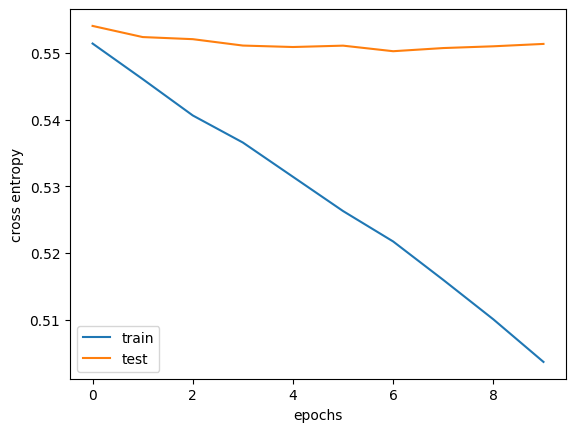

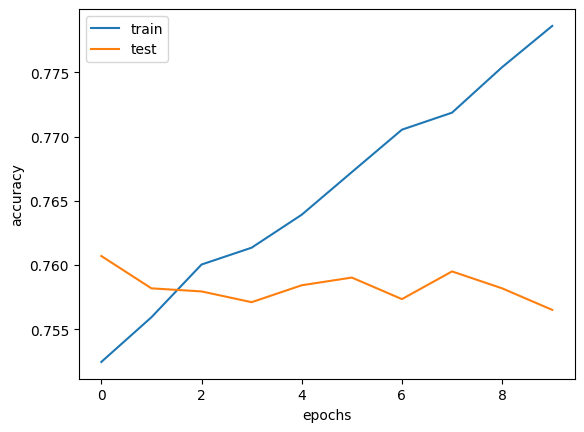

In [163]:
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()
 
plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Заметно переобучения, однако в любом случае валидационная метрика держится.

### Embedding + GRU

Воспользуемся готовым токенизатором.

In [187]:
encoded_input = tokenizer(df["review"].tolist(), padding=True, truncation=True, max_length=200,
                              add_special_tokens=False, return_tensors='pt')


In [188]:
X_ids = encoded_input['input_ids']

In [189]:
X_ids.shape

torch.Size([83441, 110])

Размер словаря.

In [190]:
vocab_size = max(tokenizer.get_vocab().values())+1

In [191]:
X_ids_train, X_ids_test = X_ids[train_index], X_ids[test_index]

Модель

In [192]:
class TextClassifier(Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = Linear(hidden_dim, hidden_dim)
        self.act = ReLU()
        self.fc_out = Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        last_hidden = output[:, -1, :]
        logits = self.fc_out(self.act(self.fc(last_hidden)))
        return logits

Начальные параметры

In [193]:
embedding_dim = 100
hidden_dim = 128
num_classes = 3
batch_size = 64
n_epochs = 5
learning_rate = 0.001

# Create the model
model = TextClassifier(vocab_size, embedding_dim, hidden_dim, num_classes)

# Define the loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [194]:
batches_per_epoch = len(X_train_t) // batch_size
 
best_acc = - np.inf  
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
 
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_ids_train[start:start+batch_size]
            y_batch = y_train_t[start:start+batch_size]
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    model.eval()
    y_pred = model(X_ids_test)
    ce = loss_fn(y_pred, y_test_t)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test_t, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")
 
# Restore best model
model.load_state_dict(best_weights)

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████| 1173/1173 [03:08<00:00,  6.23batch/s, acc=0.344, loss=1.1]


Epoch 0 validation: Cross-entropy=1.10, Accuracy=34.1%


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████| 1173/1173 [03:16<00:00,  5.96batch/s, acc=0.344, loss=1.1]


Epoch 1 validation: Cross-entropy=1.10, Accuracy=34.1%


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████| 1173/1173 [03:13<00:00,  6.05batch/s, acc=0.344, loss=1.1]


Epoch 2 validation: Cross-entropy=1.10, Accuracy=34.1%


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████| 1173/1173 [03:08<00:00,  6.21batch/s, acc=0.344, loss=1.1]


Epoch 3 validation: Cross-entropy=1.10, Accuracy=34.1%


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████| 1173/1173 [03:04<00:00,  6.36batch/s, acc=0.344, loss=1.1]


Epoch 4 validation: Cross-entropy=1.10, Accuracy=34.1%


<All keys matched successfully>

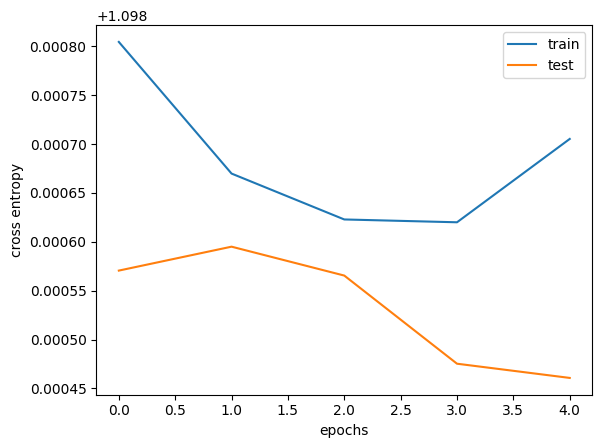

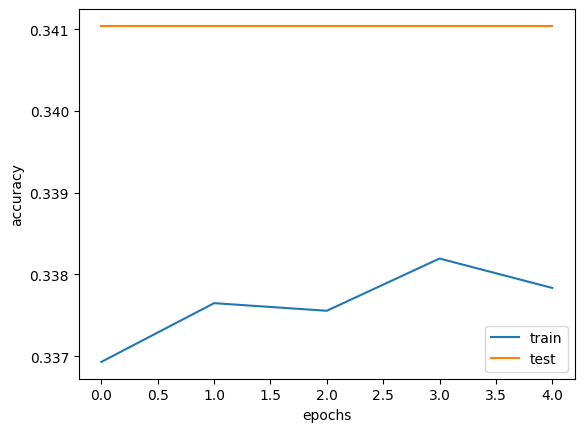

In [195]:
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()
 
plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Возможно BPE токенизатор оказался великоват. Предыдущая полносвязная модель оказалась намного лучше.

Попробуем рекурентную нейронную сеть

In [89]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        X_labse.shape[1], 64, mask_zero=True),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3)
])
 
model.summary()
 

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          49152     
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 160771 (628.01 KB)
Trainable params: 160

In [90]:
history = model.fit(
    X_train_t.numpy(), y_train_t.numpy(), 
    epochs=5,
    validation_data=(X_test_t.numpy(), y_test_t.numpy())
)

Epoch 1/5


2347/2347 [==============================] - 1592s 673ms/step - loss: 0.6370 - accuracy: 0.3364 - val_loss: 0.6367 - val_accuracy: 0.3410
Epoch 2/5
2347/2347 [==============================] - 1685s 718ms/step - loss: 0.6367 - accuracy: 0.3348 - val_loss: 0.6366 - val_accuracy: 0.3410
Epoch 3/5
2347/2347 [==============================] - 1645s 701ms/step - loss: 0.6366 - accuracy: 0.3360 - val_loss: 0.6365 - val_accuracy: 0.3345
Epoch 4/5
2347/2347 [==============================] - 1621s 691ms/step - loss: 0.6366 - accuracy: 0.3341 - val_loss: 0.6365 - val_accuracy: 0.3410
Epoch 5/5
2347/2347 [==============================] - 1634s 696ms/step - loss: 0.6366 - accuracy: 0.3359 - val_loss: 0.6370 - val_accuracy: 0.3245
